In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [41]:
# 1. Load the CSV file
df = pd.read_csv("Nat_Gas.csv")

In [42]:
# Rename columns to standard format
df.columns = ["Date", "Price"]

In [43]:
# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

C:\Users\HP\AppData\Local\Temp\ipykernel_9196\700577645.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


In [44]:
# Sort by date
df = df.sort_values("Date").reset_index(drop=True)

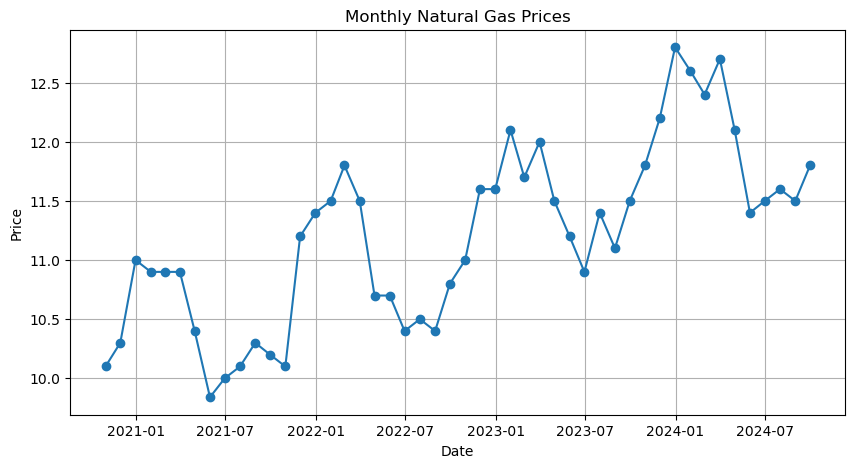

In [45]:
# 2. Visualize historical prices
plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["Price"], marker="o")
plt.title("Monthly Natural Gas Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [46]:
# 3. Identify seasonality
df["Month"] = df["Date"].dt.month
monthly_avg = df.groupby("Month")["Price"].mean()
overall_avg = df["Price"].mean()

In [47]:
# 4. Interpolation setup
df["Date_ordinal"] = df["Date"].map(pd.Timestamp.toordinal)

price_interpolator = interp1d(
    df["Date_ordinal"],
    df["Price"],
    kind="linear",
    fill_value="extrapolate"
)

In [48]:
# 5. Price estimation function
def estimate_price(input_date):
    """
    Estimate natural gas price for any given date
    """
    input_date = pd.to_datetime(input_date)
    ordinal = input_date.toordinal()

    # Base interpolated price
    base_price = float(price_interpolator(ordinal))

    # Seasonal adjustment
    month = input_date.month
    seasonal_adjustment = monthly_avg[month] - overall_avg

    return base_price + seasonal_adjustment

In [49]:
def price_storage_contract_detailed(
    injection_dates,
    withdrawal_dates,
    volume_per_action,
    max_storage_volume,
    injection_rate,
    withdrawal_rate,
    storage_cost_per_month
):
    # Convert dates
    injection_dates = [pd.to_datetime(d) for d in injection_dates]
    withdrawal_dates = [pd.to_datetime(d) for d in withdrawal_dates]

    storage_level = 0
    cashflows = []

    # Combine actions
    actions = []
    for d in injection_dates:
        actions.append((d, "inject"))
    for d in withdrawal_dates:
        actions.append((d, "withdraw"))

    actions.sort(key=lambda x: x[0])

    # Process actions
    for date, action in actions:
        price = estimate_price(date)

        if action == "inject":
            volume = min(volume_per_action, injection_rate, max_storage_volume - storage_level)
            storage_level += volume
            cashflow = -volume * price

        else:  # withdraw
            volume = min(volume_per_action, withdrawal_rate, storage_level)
            storage_level -= volume
            cashflow = volume * price

        cashflows.append({
            "Date": date,
            "Action": action,
            "Volume": volume,
            "Price": price,
            "Cashflow": cashflow,
            "Storage Level": storage_level
        })

    # Storage cost
    start_date = min(injection_dates)
    end_date = max(withdrawal_dates)

    months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
    storage_cost = months * storage_cost_per_month

    cashflows.append({
        "Date": end_date,
        "Action": "storage_cost",
        "Volume": None,
        "Price": None,
        "Cashflow": -storage_cost,
        "Storage Level": storage_level
    })

    # Results
    cashflow_df = pd.DataFrame(cashflows)
    total_value = cashflow_df["Cashflow"].sum()

    return total_value, cashflow_df

In [50]:
value, cashflows = price_storage_contract_detailed(
    injection_dates=["2024-06-01", "2024-07-01", "2024-08-01"],
    withdrawal_dates=["2024-12-01", "2025-01-01"],
    volume_per_action=200_000,
    max_storage_volume=500_000,
    injection_rate=250_000,
    withdrawal_rate=250_000,
    storage_cost_per_month=10_000
)

print(f"Contract Value: ${value:,.2f}")
cashflows

Contract Value: $-367,780.91


,Date,Action,Volume,Price,Cashflow,Storage Level
0,2024-06-01,inject,200000.0,10.896250,-2.179250e+06,200000
1,2024-07-01,inject,200000.0,11.196142,-2.239228e+06,400000
2,2024-08-01,inject,100000.0,11.214691,-1.121469e+06,500000
3,2024-12-01,withdraw,200000.0,12.912917,2.582583e+06,300000
4,2025-01-01,withdraw,200000.0,13.297917,2.659583e+06,100000
5,2025-01-01,storage_cost,NaN,NaN,-7.000000e+04,100000


In [51]:
def trade_decision(contract_value):
    if contract_value > 0:
        return "Trade is PROFITABLE"
    else:
        return "Trade is NOT profitable"

In [52]:
print(trade_decision(value))

Trade is NOT profitable


In [53]:
def optimize_injection_withdrawal(
    candidate_injection_dates,
    candidate_withdrawal_dates,
    **pricing_params
):
    results = []

    for inj in candidate_injection_dates:
        for wd in candidate_withdrawal_dates:
            value, _ = price_storage_contract_detailed(
                injection_dates=[inj],
                withdrawal_dates=[wd],
                **pricing_params
            )

            results.append({
                "Injection Date": inj,
                "Withdrawal Date": wd,
                "Contract Value": value
            })

    df = pd.DataFrame(results)
    return df.sort_values("Contract Value", ascending=False)

In [54]:
candidate_injections = [
    "2024-05-01", "2024-06-01", "2024-07-01", "2024-08-01"
]

candidate_withdrawals = [
    "2024-12-01", "2025-01-01", "2025-02-01"
]

opt_results = optimize_injection_withdrawal(
    candidate_injection_dates=candidate_injections,
    candidate_withdrawal_dates=candidate_withdrawals,
    volume_per_action=200_000,
    max_storage_volume=500_000,
    injection_rate=250_000,
    withdrawal_rate=250_000,
    storage_cost_per_month=10_000
)

opt_results.head()

,Injection Date,Withdrawal Date,Contract Value
5,2024-06-01,2025-02-01,447333.333333
4,2024-06-01,2025-01-01,410333.333333
11,2024-08-01,2025-02-01,403645.161290
8,2024-07-01,2025-02-01,397354.838710
10,2024-08-01,2025-01-01,366645.161290
